<a href="https://colab.research.google.com/github/sarahwierzbicki/projects/blob/main/NYC_Taxi_Linear_Regression_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

read parquets and csv

In [ ]:
!pip install fastparquet
import fastparquet
import pandas as pd
import numpy as np
import datetime

In [ ]:
jan_tax = pd.read_parquet('yellow_tripdata_2020-01 (1).parquet', engine='fastparquet')
jan_weather = pd.read_csv('/content/export (1).csv')
location_zones = pd.read_csv('/content/taxi_zone_lookup.csv')

In [ ]:
location_zones.columns

Index(['LocationID', 'Borough', 'Zone', 'service_zone'], dtype='object')

In [ ]:
jan_tax.head(5)
jan_tax['PULocationID']

,PULocationID
0,238
1,239
2,238
3,238
4,193
...,...
6405003,191
6405004,186
6405005,164
6405006,10


In [ ]:
location_zones

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NaN,NaN


In [ ]:
#merge taxi zone with jan to find zones of each pick up
location = location_zones.rename(columns={'LocationID': 'PULocationID'})
pickup = pd.merge(jan_tax, location, on='PULocationID', how='inner')
pickup.info()
pickup.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6405008 entries, 0 to 6405007
Data columns (total 22 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,Borough,Zone,service_zone
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1,...,0.5,1.47,0.0,0.3,11.27,2.5,NaN,Manhattan,Upper West Side North,Yellow Zone
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1,...,0.5,1.50,0.0,0.3,12.30,2.5,NaN,Manhattan,Upper West Side South,Yellow Zone
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1,...,0.5,1.00,0.0,0.3,10.80,2.5,NaN,Manhattan,Upper West Side North,Yellow Zone
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1,...,0.5,1.36,0.0,0.3,8.16,0.0,NaN,Manhattan,Upper West Side North,Yellow Zone
4,2,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,193,2,...,0.5,0.00,0.0,0.3,4.80,0.0,NaN,Queens,Queensbridge/Ravenswood,Boro Zone


Ensure drop off zone is either JFK, Newark, or LaGuardia

In [ ]:
jan_trips = pickup.loc[pickup['DOLocationID'].isin([1, 132, 138])]
jan_trips[~jan_trips['PULocationID'].isin([1, 132, 138])]
jan_trips

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,Borough,Zone,service_zone
594,2,2020-01-01 00:42:43,2020-01-01 01:06:32,1.0,7.09,1.0,N,161,138,2,...,0.5,0.00,0.00,0.3,27.80,2.5,NaN,Manhattan,Midtown Center,Yellow Zone
6047,2,2020-01-01 00:35:43,2020-01-01 01:14:31,1.0,18.34,2.0,N,249,132,1,...,0.5,12.28,6.12,0.3,73.70,2.5,NaN,Manhattan,West Village,Yellow Zone
11967,2,2020-01-01 00:17:49,2020-01-01 00:56:41,2.0,10.74,1.0,N,100,138,1,...,0.5,14.38,6.12,0.3,62.30,2.5,NaN,Manhattan,Garment District,Yellow Zone
12225,2,2020-01-01 00:34:05,2020-01-01 00:51:26,1.0,9.00,1.0,N,161,138,1,...,0.5,7.18,6.12,0.3,43.10,2.5,NaN,Manhattan,Midtown Center,Yellow Zone
12382,1,2020-01-01 00:39:15,2020-01-01 00:39:50,1.0,0.00,1.0,N,132,132,4,...,0.5,0.00,0.00,0.3,3.80,0.0,NaN,Queens,JFK Airport,Airports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6402566,2,2020-01-30 16:11:00,2020-01-30 17:39:00,NaN,20.32,NaN,None,232,132,0,...,0.5,0.00,0.00,0.3,58.79,NaN,NaN,Manhattan,Two Bridges/Seward Park,Yellow Zone
6403262,2,2020-01-31 05:57:09,2020-01-31 06:10:51,NaN,7.60,NaN,None,216,138,0,...,0.0,0.00,0.00,0.3,43.00,NaN,NaN,Queens,South Ozone Park,Boro Zone
6404051,2,2020-01-31 13:00:47,2020-01-31 13:57:22,NaN,34.11,NaN,None,140,132,0,...,0.0,0.00,6.12,0.3,48.58,NaN,NaN,Manhattan,Lenox Hill East,Yellow Zone
6404186,2,2020-01-31 14:02:00,2020-01-31 14:16:00,NaN,8.27,NaN,None,9,138,0,...,0.5,0.00,0.00,0.3,28.41,NaN,NaN,Queens,Auburndale,Boro Zone


In [ ]:
#rename drop off to airport
def airport(x):
  if x == 1:
      return 'Newark'
  elif x == 132:
      return 'JFK'
  elif x == 138:
      return 'LaGuardia'


In [ ]:
jan_trips['airport']=jan_trips['DOLocationID'].apply(airport)

<ipython-input-211-d58d2a0e0153>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jan_trips['airport']=jan_trips['DOLocationID'].apply(airport)


In [ ]:
# drop NaN from RateCodeID and those not between 1 and 6
jan_trips.dropna(subset=['RatecodeID'])

#drop NaN from passenger count
jan_trips.dropna(subset=['passenger_count'])


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,Borough,Zone,service_zone,airport
594,2,2020-01-01 00:42:43,2020-01-01 01:06:32,1.0,7.09,1.0,N,161,138,2,...,0.00,0.00,0.3,27.8,2.5,NaN,Manhattan,Midtown Center,Yellow Zone,LaGuardia
6047,2,2020-01-01 00:35:43,2020-01-01 01:14:31,1.0,18.34,2.0,N,249,132,1,...,12.28,6.12,0.3,73.7,2.5,NaN,Manhattan,West Village,Yellow Zone,JFK
11967,2,2020-01-01 00:17:49,2020-01-01 00:56:41,2.0,10.74,1.0,N,100,138,1,...,14.38,6.12,0.3,62.3,2.5,NaN,Manhattan,Garment District,Yellow Zone,LaGuardia
12225,2,2020-01-01 00:34:05,2020-01-01 00:51:26,1.0,9.00,1.0,N,161,138,1,...,7.18,6.12,0.3,43.1,2.5,NaN,Manhattan,Midtown Center,Yellow Zone,LaGuardia
12382,1,2020-01-01 00:39:15,2020-01-01 00:39:50,1.0,0.00,1.0,N,132,132,4,...,0.00,0.00,0.3,3.8,0.0,NaN,Queens,JFK Airport,Airports,JFK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6338772,1,2020-01-31 23:00:14,2020-01-31 23:00:22,1.0,0.00,1.0,N,132,132,4,...,0.00,0.00,0.3,3.8,0.0,NaN,Queens,JFK Airport,Airports,JFK
6338928,1,2020-01-31 23:12:30,2020-01-31 23:20:40,1.0,1.30,1.0,N,138,138,2,...,0.00,0.00,0.3,9.3,0.0,NaN,Queens,LaGuardia Airport,Airports,LaGuardia
6339436,1,2020-01-31 23:51:05,2020-01-31 23:51:08,1.0,0.00,1.0,N,132,132,3,...,0.00,0.00,0.3,3.8,0.0,NaN,Queens,JFK Airport,Airports,JFK
6339465,2,2020-01-31 23:54:51,2020-01-31 23:56:50,1.0,0.05,2.0,N,132,132,2,...,0.00,0.00,0.3,52.8,0.0,NaN,Queens,JFK Airport,Airports,JFK


In [ ]:
#remove unneeded columns
jan_trips.drop('VendorID', axis = 1, inplace=True)
jan_trips.drop('store_and_fwd_flag', axis = 1, inplace=True)
jan_trips.drop('airport_fee', axis = 1, inplace=True)
jan_trips.drop('congestion_surcharge', axis = 1, inplace=True)
jan_trips.drop('payment_type', axis = 1, inplace=True)
jan_trips.drop('extra', axis = 1, inplace=True)
jan_trips.drop('service_zone', axis = 1, inplace=True)

<ipython-input-213-ab0e33609de2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jan_trips.drop('VendorID', axis = 1, inplace=True)
<ipython-input-213-ab0e33609de2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jan_trips.drop('store_and_fwd_flag', axis = 1, inplace=True)
<ipython-input-213-ab0e33609de2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jan_trips.drop('airport_fee', axis = 1, inplace=True)
<ipython-input-213-ab0e3360

In [ ]:
#ride count by timeframe
#add column for 5 timeframe (morning (5-12), afternoon(12-4), evening(4-10), latenight(10-5))
def time_frame(x):
  if x in range(5,12):
      return 1
  elif x in range(12,16):
      return 2
  elif x in range(16,22):
      return 3
  else:
      return 4

In [ ]:
jan_trips['pickup_day'] = jan_trips['tpep_pickup_datetime'].dt.day_name()
jan_trips['dropoff_day'] = jan_trips['tpep_dropoff_datetime'].dt.day_name()

jan_trips['pickup_hour']= jan_trips['tpep_pickup_datetime'].dt.hour
jan_trips['dropoff_hour']= jan_trips['tpep_dropoff_datetime'].dt.hour

jan_trips['date']=jan_trips['tpep_pickup_datetime'].dt.date
jan_trips['date'] = pd.to_datetime(jan_trips['date'])

day_int = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
jan_trips['day_of_week'] = jan_trips['pickup_day'].map(day_int)

<ipython-input-215-63d98eac02ab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jan_trips['pickup_day'] = jan_trips['tpep_pickup_datetime'].dt.day_name()
<ipython-input-215-63d98eac02ab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jan_trips['dropoff_day'] = jan_trips['tpep_dropoff_datetime'].dt.day_name()
<ipython-input-215-63d98eac02ab>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [ ]:
jan_trips['pickup_timeframe']=jan_trips['pickup_hour'].apply(time_frame)
jan_trips['dropoff_timeframe']=jan_trips['dropoff_hour'].apply(time_frame)

<ipython-input-216-a2e1009a72eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jan_trips['pickup_timeframe']=jan_trips['pickup_hour'].apply(time_frame)
<ipython-input-216-a2e1009a72eb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jan_trips['dropoff_timeframe']=jan_trips['dropoff_hour'].apply(time_frame)


In [ ]:
from datetime import datetime
from datetime import timedelta
a = jan_trips['tpep_pickup_datetime']
b = jan_trips['tpep_dropoff_datetime']
c = b - a
c.describe()

,0
count,128147
mean,0 days 00:35:20.650682419
std,0 days 01:18:25.275711972
min,0 days 00:00:00
25%,0 days 00:21:50
50%,0 days 00:29:39
75%,0 days 00:39:32
max,0 days 23:59:56


In [ ]:
from datetime import datetime
from datetime import timedelta
a = jan_trips['tpep_pickup_datetime']
b = jan_trips['tpep_dropoff_datetime']
c = b - a
min = c.dt.total_seconds() / 60
jan_trips['ride_duration'] = min
jan_trips['ride_duration'] = jan_trips['ride_duration'].round(2)


<ipython-input-218-7989dd795677>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jan_trips['ride_duration'] = min
<ipython-input-218-7989dd795677>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jan_trips['ride_duration'] = jan_trips['ride_duration'].round(2)


In [ ]:
# drop NaN from RateCodeID and those not between 1 and 6
jan_trips.dropna(subset=['RatecodeID'])

#drop NaN from passenger count
jan_trips.dropna(subset=['passenger_count'])


#find zones in manhattan
man_trips = jan_trips[jan_trips['Borough'] == 'Manhattan']

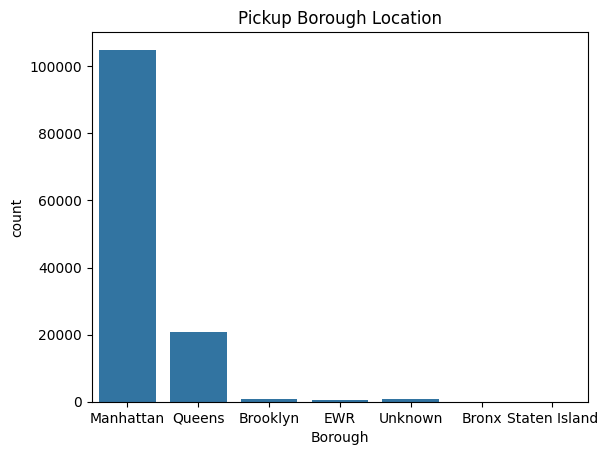

In [ ]:
#show pickups by borough
import seaborn as sns
timeframe_plot = sns.countplot(data=jan_trips, x='Borough')
timeframe_plot.set(title = 'Pickup Borough Location')
timeframe_plot.ticklabel_format(style='plain', axis='y')

In [ ]:
man_trips_filtered = man_trips[man_trips['Zone'].isin(man_trips['Zone'].value_counts()[man_trips['Zone'].value_counts() >= 1000].index)]

<ipython-input-222-d36c0b9aa6e7>:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  zone_plot.set_xticklabels(zone_plot.get_xticklabels(), rotation=90)


[Text(0, 0, 'Midtown Center'),
 Text(1, 0, 'Garment District'),
 Text(2, 0, 'Midtown East'),
 Text(3, 0, 'Upper West Side North'),
 Text(4, 0, 'West Chelsea/Hudson Yards'),
 Text(5, 0, 'Midtown North'),
 Text(6, 0, 'Lincoln Square East'),
 Text(7, 0, 'Clinton East'),
 Text(8, 0, 'Murray Hill'),
 Text(9, 0, 'Midtown South'),
 Text(10, 0, 'Lenox Hill West'),
 Text(11, 0, 'Times Sq/Theatre District'),
 Text(12, 0, 'East Chelsea'),
 Text(13, 0, 'Financial District North'),
 Text(14, 0, 'Union Sq'),
 Text(15, 0, 'Upper East Side North'),
 Text(16, 0, 'Penn Station/Madison Sq West'),
 Text(17, 0, 'Sutton Place/Turtle Bay North'),
 Text(18, 0, 'TriBeCa/Civic Center'),
 Text(19, 0, 'East Village'),
 Text(20, 0, 'Yorkville East'),
 Text(21, 0, 'Central Park'),
 Text(22, 0, 'Upper East Side South'),
 Text(23, 0, 'Upper West Side South'),
 Text(24, 0, 'Gramercy'),
 Text(25, 0, 'Battery Park City'),
 Text(26, 0, 'Yorkville West'),
 Text(27, 0, 'World Trade Center'),
 Text(28, 0, 'Flatiron'),
 Text

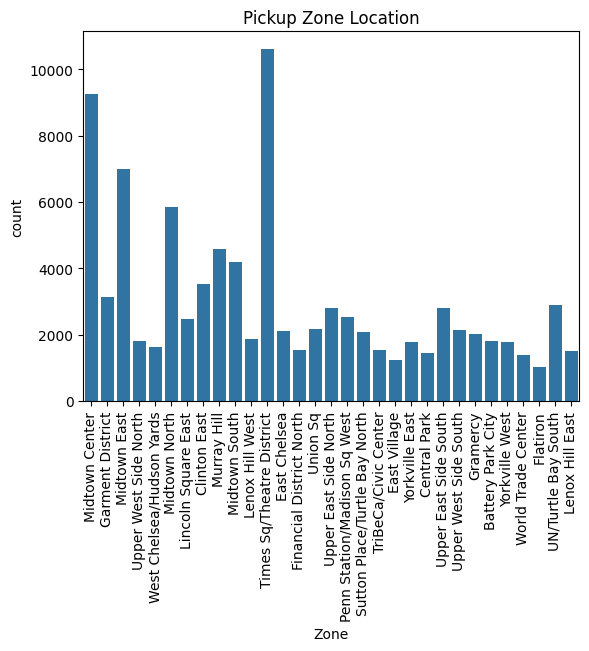

In [ ]:
#show pickups by zone
zone_plot = sns.countplot(data=man_trips_filtered, x='Zone')
zone_plot.set(title = 'Pickup Zone Location')
zone_plot.ticklabel_format(style='plain', axis='y')
zone_plot.set_xticklabels(zone_plot.get_xticklabels(), rotation=90)

<ipython-input-223-6b715b486b87>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  zone_plot_ride.set_xticklabels(zone_plot.get_xticklabels(), rotation=90)


[Text(0, 0, 'Midtown Center'),
 Text(1, 0, 'Garment District'),
 Text(2, 0, 'Midtown East'),
 Text(3, 0, 'Upper West Side North'),
 Text(4, 0, 'West Chelsea/Hudson Yards'),
 Text(5, 0, 'Midtown North'),
 Text(6, 0, 'Lincoln Square East'),
 Text(7, 0, 'Clinton East'),
 Text(8, 0, 'Murray Hill'),
 Text(9, 0, 'Midtown South'),
 Text(10, 0, 'Lenox Hill West'),
 Text(11, 0, 'Times Sq/Theatre District'),
 Text(12, 0, 'East Chelsea'),
 Text(13, 0, 'Financial District North'),
 Text(14, 0, 'Union Sq'),
 Text(15, 0, 'Upper East Side North'),
 Text(16, 0, 'Penn Station/Madison Sq West'),
 Text(17, 0, 'Sutton Place/Turtle Bay North'),
 Text(18, 0, 'TriBeCa/Civic Center'),
 Text(19, 0, 'East Village'),
 Text(20, 0, 'Yorkville East'),
 Text(21, 0, 'Central Park'),
 Text(22, 0, 'Upper East Side South'),
 Text(23, 0, 'Upper West Side South'),
 Text(24, 0, 'Gramercy'),
 Text(25, 0, 'Battery Park City'),
 Text(26, 0, 'Yorkville West'),
 Text(27, 0, 'World Trade Center'),
 Text(28, 0, 'Flatiron'),
 Text

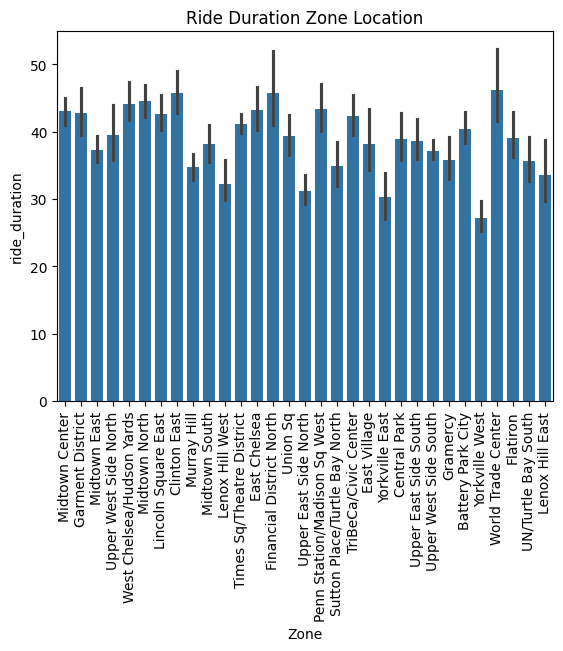

In [ ]:
zone_plot_ride = sns.barplot(data=man_trips_filtered, x='Zone', y = 'ride_duration')
zone_plot_ride.set(title = 'Ride Duration Zone Location')
zone_plot_ride.ticklabel_format(style='plain', axis='y')
zone_plot_ride.set_xticklabels(zone_plot.get_xticklabels(), rotation=90)

In [ ]:
man_trips_filtered.describe()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_hour,dropoff_hour,date,day_of_week,pickup_timeframe,dropoff_timeframe,ride_duration
count,92546,92546,92505.000000,92546.000000,92505.000000,92546.000000,92546.000000,92546.000000,92546.000000,92546.000000,92546.000000,92546.000000,92546.000000,92546.000000,92546.000000,92546,92546.000000,92546.000000,92546.000000,92546.000000
mean,2020-01-17 00:23:48.866671872,2020-01-17 01:03:19.549867008,1.575299,13.852981,1.602551,173.083872,121.880762,43.041810,0.448020,8.044445,6.166085,0.299306,60.639568,11.774069,12.323126,2020-01-16 12:08:05.466686976,2.931602,1.902016,1.954444,39.511384
min,2008-12-31 23:02:40,2009-01-01 00:51:18,0.000000,0.000000,1.000000,13.000000,1.000000,-120.000000,-0.500000,0.000000,-19.750000,-0.300000,-135.300000,0.000000,0.000000,2008-12-31 00:00:00,0.000000,1.000000,1.000000,0.000000
25%,2020-01-09 15:58:02.500000,2020-01-09 16:41:56.249999872,1.000000,9.890000,1.000000,142.000000,132.000000,30.500000,0.500000,5.000000,6.120000,0.300000,46.300000,8.000000,9.000000,2020-01-09 00:00:00,2.000000,1.000000,1.000000,25.070000
50%,2020-01-16 17:43:53,2020-01-16 18:39:48.500000,1.000000,13.100000,1.000000,164.000000,138.000000,41.500000,0.500000,8.280000,6.120000,0.300000,57.420000,12.000000,13.000000,2020-01-16 00:00:00,3.000000,2.000000,2.000000,31.780000
75%,2020-01-24 12:04:19.500000,2020-01-24 12:41:45.500000,2.000000,17.380000,2.000000,230.000000,138.000000,52.000000,0.500000,12.080000,6.120000,0.300000,73.670000,15.000000,16.000000,2020-01-24 00:00:00,4.000000,3.000000,3.000000,41.280000
max,2020-01-31 23:54:43,2020-02-01 15:24:56,8.000000,63.680000,5.000000,263.000000,138.000000,221.000000,0.500000,100.200000,700.870000,0.300000,735.170000,23.000000,23.000000,2020-01-31 00:00:00,6.000000,4.000000,4.000000,1439.930000
std,NaN,NaN,1.182540,4.380870,0.755757,62.841369,40.723983,14.244846,0.153839,5.374841,4.830852,0.019059,18.828317,4.281924,4.383266,NaN,1.844712,0.874090,0.874192,81.785568


In [ ]:
#handle outliers

#minimum distance 1 mile
trips_dis = man_trips_filtered[(man_trips_filtered['trip_distance'] > 5) & (man_trips_filtered['trip_distance'] < 25)]
#minimum fare 10 dollars
trips_fare = trips_dis[(trips_dis['fare_amount'] > 10) & (trips_dis['fare_amount'] < 100)]
#minimum ride time of 10 minutes
trips_final = trips_fare[(trips_fare['ride_duration'] > 10) & (trips_dis['ride_duration'] < 100)]
#drop NaN from RateCodeID and those not between 1 and 6
trips_final = trips_final.dropna(subset=['RatecodeID'])

#drop NaN from passenger count
trips_final = trips_final.dropna(subset=['passenger_count'])



<ipython-input-225-8ad7db49574b>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  trips_final = trips_fare[(trips_fare['ride_duration'] > 10) & (trips_dis['ride_duration'] < 100)]


In [ ]:
from scipy import stats

trips_final = trips_final[np.abs(stats.zscore(trips_final['trip_distance'])) < 3]
trips_final = trips_final[np.abs(stats.zscore(trips_final['ride_duration'])) < 3]

In [ ]:
jan_weather.head(5)

,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2020-01-01 00:00:00,3.6,1.7,5.0,NaN,NaN,NaN,17.3,NaN,1008.2,NaN
1,2020-01-02 00:00:00,4.7,0.6,8.9,NaN,NaN,NaN,12.4,NaN,1013.9,NaN
2,2020-01-03 00:00:00,7.6,6.7,8.3,NaN,NaN,257.0,8.4,NaN,1010.2,NaN
3,2020-01-04 00:00:00,8.2,6.7,9.4,NaN,NaN,NaN,5.7,NaN,1003.7,NaN
4,2020-01-05 00:00:00,4.6,2.8,7.2,NaN,NaN,NaN,8.2,NaN,1010.1,NaN


In [ ]:
jan_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    31 non-null     object 
 1   tavg    30 non-null     float64
 2   tmin    30 non-null     float64
 3   tmax    30 non-null     float64
 4   prcp    0 non-null      float64
 5   snow    0 non-null      float64
 6   wdir    8 non-null      float64
 7   wspd    30 non-null     float64
 8   wpgt    0 non-null      float64
 9   pres    30 non-null     float64
 10  tsun    0 non-null      float64
dtypes: float64(10), object(1)
memory usage: 2.8+ KB


In [ ]:
#convert date to datetime
jan_weather['date'] = pd.to_datetime(jan_weather['date'])
jan_weather.info()

#drop columns with no values
jan_weather.drop('prcp', axis = 1, inplace=True)
jan_weather.drop('snow', axis = 1, inplace=True)
jan_weather.drop('wpgt', axis = 1, inplace=True)
jan_weather.drop('tsun', axis = 1, inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    31 non-null     datetime64[ns]
 1   tavg    30 non-null     float64       
 2   tmin    30 non-null     float64       
 3   tmax    30 non-null     float64       
 4   prcp    0 non-null      float64       
 5   snow    0 non-null      float64       
 6   wdir    8 non-null      float64       
 7   wspd    30 non-null     float64       
 8   wpgt    0 non-null      float64       
 9   pres    30 non-null     float64       
 10  tsun    0 non-null      float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 2.8 KB


In [ ]:
#convert C to F
def convert(x):
  tempavg = (x * 9/5) + 32
  return tempavg

In [ ]:
jan_weather['temp_average']=jan_weather['tavg'].apply(convert)
jan_weather['temp_min']=jan_weather['tmin'].apply(convert)
jan_weather['temp_max']=jan_weather['tmax'].apply(convert)
jan_weather_2 = jan_weather.drop(12)
jan_weather_2
#dropped row of 1/13; had no info

,date,tavg,tmin,tmax,wdir,wspd,pres,temp_average,temp_min,temp_max
0,2020-01-01,3.6,1.7,5.0,NaN,17.3,1008.2,38.48,35.06,41.00
1,2020-01-02,4.7,0.6,8.9,NaN,12.4,1013.9,40.46,33.08,48.02
2,2020-01-03,7.6,6.7,8.3,257.0,8.4,1010.2,45.68,44.06,46.94
3,2020-01-04,8.2,6.7,9.4,NaN,5.7,1003.7,46.76,44.06,48.92
4,2020-01-05,4.6,2.8,7.2,NaN,8.2,1010.1,40.28,37.04,44.96
5,2020-01-06,4.0,0.6,7.2,256.0,15.9,1015.3,39.20,33.08,44.96
6,2020-01-07,4.7,3.3,6.7,286.0,10.4,1016.2,40.46,37.94,44.06
7,2020-01-08,2.6,-0.6,6.7,NaN,13.4,1016.6,36.68,30.92,44.06
8,2020-01-09,-0.6,-3.3,2.2,NaN,9.1,1038.8,30.92,26.06,35.96
9,2020-01-10,6.4,1.1,11.7,265.0,14.5,1034.5,43.52,33.98,53.06


In [ ]:
#merge on date
df = pd.merge(trips_final, jan_weather_2, on='date', how='inner')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86951 entries, 0 to 86950
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tpep_pickup_datetime   86951 non-null  datetime64[ns]
 1   tpep_dropoff_datetime  86951 non-null  datetime64[ns]
 2   passenger_count        86951 non-null  float64       
 3   trip_distance          86951 non-null  float64       
 4   RatecodeID             86951 non-null  float64       
 5   PULocationID           86951 non-null  int64         
 6   DOLocationID           86951 non-null  int64         
 7   fare_amount            86951 non-null  float64       
 8   mta_tax                86951 non-null  float64       
 9   tip_amount             86951 non-null  float64       
 10  tolls_amount           86951 non-null  float64       
 11  improvement_surcharge  86951 non-null  float64       
 12  total_amount           86951 non-null  float64       
 13  B

In [ ]:
df['temp_average'] = df['temp_average'].round(2)

<ipython-input-234-5fd0ec1a6939>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  climate_plot.set_xticklabels(climate_plot.get_xticklabels(), rotation=90)


[Text(0, 0, '28.04'),
 Text(1, 0, '28.94'),
 Text(2, 0, '29.3'),
 Text(3, 0, '29.84'),
 Text(4, 0, '30.92'),
 Text(5, 0, '33.8'),
 Text(6, 0, '34.34'),
 Text(7, 0, '36.68'),
 Text(8, 0, '38.3'),
 Text(9, 0, '38.48'),
 Text(10, 0, '39.2'),
 Text(11, 0, '39.74'),
 Text(12, 0, '40.28'),
 Text(13, 0, '40.46'),
 Text(14, 0, '40.82'),
 Text(15, 0, '41.18'),
 Text(16, 0, '41.9'),
 Text(17, 0, '43.34'),
 Text(18, 0, '43.52'),
 Text(19, 0, '43.7'),
 Text(20, 0, '43.88'),
 Text(21, 0, '44.06'),
 Text(22, 0, '45.68'),
 Text(23, 0, '46.76'),
 Text(24, 0, '58.28'),
 Text(25, 0, '60.26')]

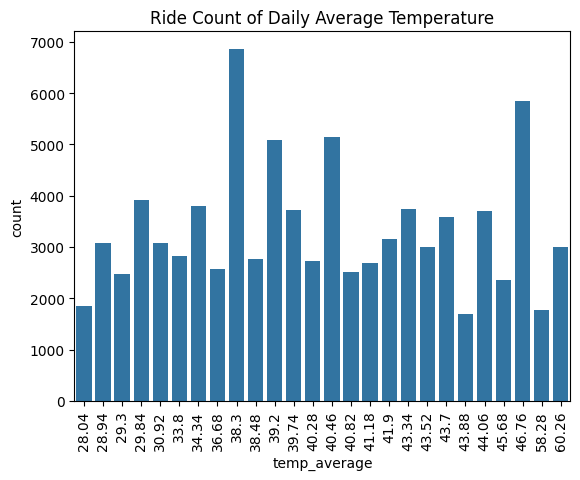

In [ ]:
climate_plot = sns.countplot(data=df, x = 'temp_average')
climate_plot.set(title = 'Ride Count of Daily Average Temperature')
climate_plot.ticklabel_format(style='plain', axis='y')
climate_plot.set_xticklabels(climate_plot.get_xticklabels(), rotation=90)

<ipython-input-235-0185c8155595>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  climate_plot_ride.set_xticklabels(climate_plot.get_xticklabels(), rotation=90)


[Text(0, 0, '28.04'),
 Text(1, 0, '28.94'),
 Text(2, 0, '29.3'),
 Text(3, 0, '29.84'),
 Text(4, 0, '30.92'),
 Text(5, 0, '33.8'),
 Text(6, 0, '34.34'),
 Text(7, 0, '36.68'),
 Text(8, 0, '38.3'),
 Text(9, 0, '38.48'),
 Text(10, 0, '39.2'),
 Text(11, 0, '39.74'),
 Text(12, 0, '40.28'),
 Text(13, 0, '40.46'),
 Text(14, 0, '40.82'),
 Text(15, 0, '41.18'),
 Text(16, 0, '41.9'),
 Text(17, 0, '43.34'),
 Text(18, 0, '43.52'),
 Text(19, 0, '43.7'),
 Text(20, 0, '43.88'),
 Text(21, 0, '44.06'),
 Text(22, 0, '45.68'),
 Text(23, 0, '46.76'),
 Text(24, 0, '58.28'),
 Text(25, 0, '60.26')]

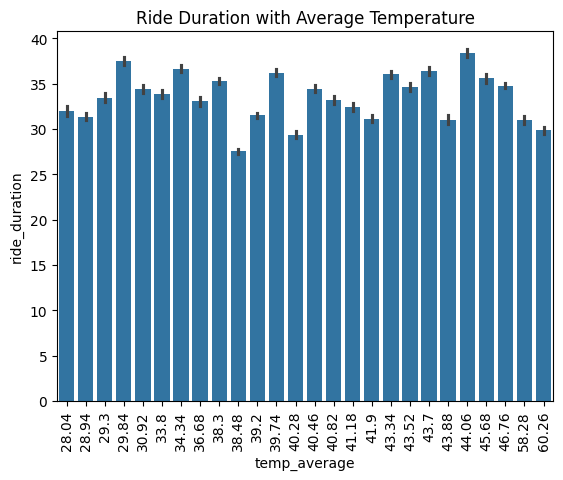

In [ ]:
climate_plot_ride = sns.barplot(data=df, x='temp_average', y = 'ride_duration')
climate_plot_ride.set(title = 'Ride Duration with Average Temperature')
climate_plot_ride.ticklabel_format(style='plain', axis='y')
climate_plot_ride.set_xticklabels(climate_plot.get_xticklabels(), rotation=90)

pre-process and clean for model feeding

In [ ]:
from datetime import datetime
day = df['date']
df['day_of_month'] = day.dt.day

In [ ]:
df['day_of_month']

,day_of_month
0,1
1,1
2,1
3,1
4,1
...,...
86946,31
86947,31
86948,31
86949,31


In [ ]:
#fill nan with 0
df['wdir'].fillna(0, inplace=True)

<ipython-input-238-727fb0c18c48>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['wdir'].fillna(0, inplace=True)


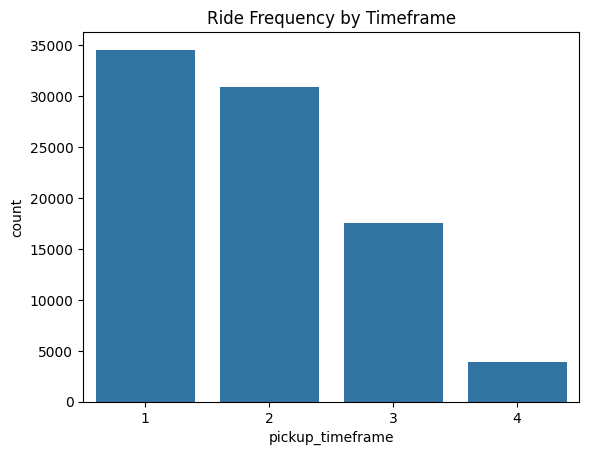

In [ ]:
timeframe_plot = sns.countplot(data=df, x='pickup_timeframe')
timeframe_plot.set(title = 'Ride Frequency by Timeframe')
timeframe_plot.ticklabel_format(style='plain', axis='y')

<Axes: xlabel='pickup_timeframe', ylabel='ride_duration'>

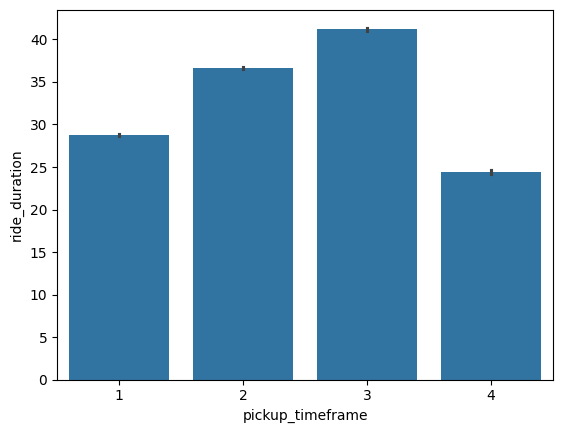

In [ ]:
sns.barplot(data=df, x= 'pickup_timeframe', y = 'ride_duration')

<ipython-input-241-d9ef42bfc422>:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(zone_plot.get_xticklabels(), rotation=90)


[Text(0, 0, 'Midtown Center'),
 Text(1, 0, 'Garment District'),
 Text(2, 0, 'Midtown East'),
 Text(3, 0, 'Upper West Side North'),
 Text(4, 0, 'West Chelsea/Hudson Yards'),
 Text(5, 0, 'Midtown North'),
 Text(6, 0, 'Lincoln Square East'),
 Text(7, 0, 'Clinton East'),
 Text(8, 0, 'Murray Hill'),
 Text(9, 0, 'Midtown South'),
 Text(10, 0, 'Lenox Hill West'),
 Text(11, 0, 'Times Sq/Theatre District'),
 Text(12, 0, 'East Chelsea'),
 Text(13, 0, 'Financial District North'),
 Text(14, 0, 'Union Sq'),
 Text(15, 0, 'Upper East Side North'),
 Text(16, 0, 'Penn Station/Madison Sq West'),
 Text(17, 0, 'Sutton Place/Turtle Bay North'),
 Text(18, 0, 'TriBeCa/Civic Center'),
 Text(19, 0, 'East Village'),
 Text(20, 0, 'Yorkville East'),
 Text(21, 0, 'Central Park'),
 Text(22, 0, 'Upper East Side South'),
 Text(23, 0, 'Upper West Side South'),
 Text(24, 0, 'Gramercy'),
 Text(25, 0, 'Battery Park City'),
 Text(26, 0, 'Yorkville West'),
 Text(27, 0, 'World Trade Center'),
 Text(28, 0, 'Flatiron'),
 Text

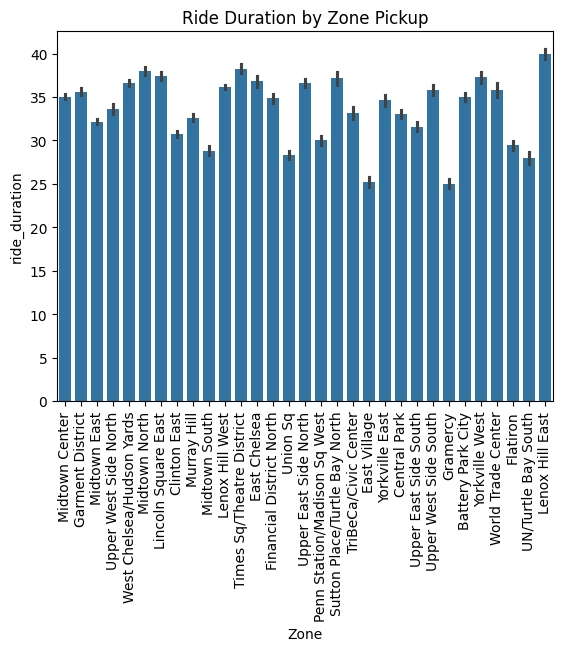

In [ ]:
bar_plot = sns.barplot(data=df, x= 'Zone', y = 'ride_duration')

bar_plot.set(title = 'Ride Duration by Zone Pickup')
bar_plot.ticklabel_format(style='plain', axis='y')
bar_plot.set_xticklabels(zone_plot.get_xticklabels(), rotation=90)

<Axes: xlabel='airport', ylabel='ride_duration'>

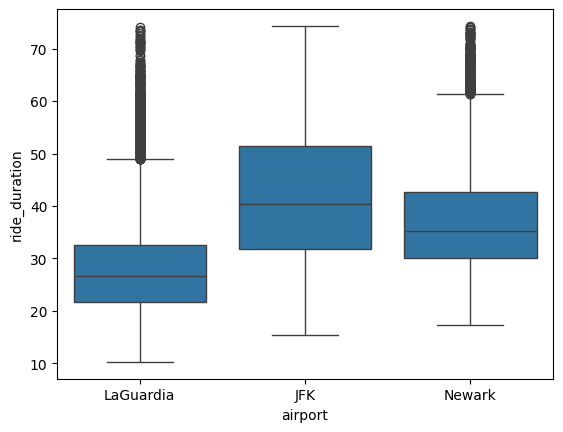

In [ ]:
import seaborn as sns
sns.boxplot(data = df, x = 'airport', y = 'ride_duration')

In [ ]:
for col in['airport', 'Zone']:
  df[col] = df[col].astype('category')
df.dtypes

,0
tpep_pickup_datetime,datetime64[ns]
tpep_dropoff_datetime,datetime64[ns]
passenger_count,float64
trip_distance,float64
RatecodeID,float64
PULocationID,int64
DOLocationID,int64
fare_amount,float64
mta_tax,float64
tip_amount,float64


In [ ]:
df.Zone.value_counts().sort_values(ascending=False).count()


np.int64(31)

In [ ]:
df['airport_code'] = df['airport'].astype('category').cat.codes
df['zone_code'] = df['Zone'].astype('category').cat.codes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86951 entries, 0 to 86950
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tpep_pickup_datetime   86951 non-null  datetime64[ns]
 1   tpep_dropoff_datetime  86951 non-null  datetime64[ns]
 2   passenger_count        86951 non-null  float64       
 3   trip_distance          86951 non-null  float64       
 4   RatecodeID             86951 non-null  float64       
 5   PULocationID           86951 non-null  int64         
 6   DOLocationID           86951 non-null  int64         
 7   fare_amount            86951 non-null  float64       
 8   mta_tax                86951 non-null  float64       
 9   tip_amount             86951 non-null  float64       
 10  tolls_amount           86951 non-null  float64       
 11  improvement_surcharge  86951 non-null  float64       
 12  total_amount           86951 non-null  float64       
 13  B

In [ ]:
model_df = df[['trip_distance', 'zone_code', 'ride_duration', 'pickup_hour', 'airport_code', 'day_of_month', 'temp_average']]
model_df['zone_code']

,zone_code
0,12
1,7
2,12
3,13
4,25
...,...
86946,7
86947,7
86948,13
86949,20


In [ ]:
model_df.head(5)

,trip_distance,zone_code,ride_duration,pickup_hour,airport_code,day_of_month,temp_average
0,7.09,12,23.82,0,1,1,38.48
1,10.74,7,38.87,0,1,1,38.48
2,9.00,12,17.35,0,1,1,38.48
3,17.65,13,47.55,0,0,1,38.48
4,20.65,25,38.85,1,0,1,38.48


linear regression

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.keras.layers import CategoryEncoding
import keras
import numpy as np

In [ ]:
model_df.zone_code.unique()
#31 unique codes

array([12,  7, 13, 25, 14, 11,  2, 16, 15, 10, 19,  3,  5, 22, 23, 17, 18,
       20,  4, 29,  1, 24,  8,  0, 30, 26, 28,  6, 21,  9, 27], dtype=int8)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
cat_cols = ['airport_code', 'zone_code', 'pickup_hour', 'day_of_month']
model_df = pd.get_dummies(model_df, columns= cat_cols, dtype= int)
model_df

,trip_distance,ride_duration,temp_average,airport_code_0,airport_code_1,airport_code_2,zone_code_0,zone_code_1,zone_code_2,zone_code_3,...,day_of_month_22,day_of_month_23,day_of_month_24,day_of_month_25,day_of_month_26,day_of_month_27,day_of_month_28,day_of_month_29,day_of_month_30,day_of_month_31
0,7.09,23.82,38.48,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10.74,38.87,38.48,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9.00,17.35,38.48,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,17.65,47.55,38.48,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20.65,38.85,38.48,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86946,16.90,33.50,39.74,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
86947,17.16,36.88,39.74,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
86948,16.87,29.98,39.74,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
86949,12.93,26.58,39.74,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
model_df

,trip_distance,ride_duration,temp_average,airport_code_0,airport_code_1,airport_code_2,zone_code_0,zone_code_1,zone_code_2,zone_code_3,...,day_of_month_22,day_of_month_23,day_of_month_24,day_of_month_25,day_of_month_26,day_of_month_27,day_of_month_28,day_of_month_29,day_of_month_30,day_of_month_31
0,7.09,23.82,38.48,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10.74,38.87,38.48,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9.00,17.35,38.48,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,17.65,47.55,38.48,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20.65,38.85,38.48,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86946,16.90,33.50,39.74,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
86947,17.16,36.88,39.74,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
86948,16.87,29.98,39.74,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
86949,12.93,26.58,39.74,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
train_data, test_data = np.split(model_df, [int(0.8*len(model_df))])


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
train_data, val_data = np.split(train_data.sample(frac=1), [int(0.8*len(train_data))])

In [ ]:
train_data

,trip_distance,ride_duration,temp_average,airport_code_0,airport_code_1,airport_code_2,zone_code_0,zone_code_1,zone_code_2,zone_code_3,...,day_of_month_22,day_of_month_23,day_of_month_24,day_of_month_25,day_of_month_26,day_of_month_27,day_of_month_28,day_of_month_29,day_of_month_30,day_of_month_31
7137,17.23,30.17,45.68,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48314,8.90,15.68,39.20,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44304,15.63,41.25,29.84,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4012,9.02,24.35,40.46,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39183,17.55,35.85,44.06,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69168,16.64,30.35,41.90,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
57465,15.13,57.72,33.80,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
26140,13.95,30.12,43.52,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42734,18.40,28.70,29.84,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
val_data

,trip_distance,ride_duration,temp_average,airport_code_0,airport_code_1,airport_code_2,zone_code_0,zone_code_1,zone_code_2,zone_code_3,...,day_of_month_22,day_of_month_23,day_of_month_24,day_of_month_25,day_of_month_26,day_of_month_27,day_of_month_28,day_of_month_29,day_of_month_30,day_of_month_31
38174,9.90,33.10,46.76,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12601,13.17,29.15,40.28,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51337,11.00,22.87,28.94,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21455,11.00,31.03,30.92,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1164,8.82,14.78,38.48,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58082,11.30,29.68,33.80,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
60201,11.80,34.28,38.30,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
6079,7.75,17.35,45.68,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36833,9.69,26.32,46.76,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(len(train_data), 'training examples')
print(len(test_data), 'test examples')
print(len(val_data), 'val examples')

55648 training examples
17391 test examples
13912 val examples


In [ ]:
train_labels = train_data.pop('ride_duration')
test_labels = test_data.pop('ride_duration')
val_labels = val_data.pop('ride_duration')

In [ ]:
#use sklearn minmaxscaler for training and validaton
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns_to_scale = ['trip_distance', 'temp_average']
train_data[columns_to_scale] = scaler.fit_transform(train_data[columns_to_scale])
val_data[columns_to_scale] = scaler.fit_transform(val_data[columns_to_scale])
test_data[columns_to_scale] = scaler.fit_transform(test_data[columns_to_scale])

In [ ]:
test_data

,trip_distance,temp_average,airport_code_0,airport_code_1,airport_code_2,zone_code_0,zone_code_1,zone_code_2,zone_code_3,zone_code_4,...,day_of_month_22,day_of_month_23,day_of_month_24,day_of_month_25,day_of_month_26,day_of_month_27,day_of_month_28,day_of_month_29,day_of_month_30,day_of_month_31
69560,0.642633,1.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
69561,0.160920,1.000000,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
69562,0.647858,1.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
69563,0.715778,1.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
69564,0.310345,1.000000,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86946,0.585162,0.714286,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
86947,0.598746,0.714286,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
86948,0.583595,0.714286,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
86949,0.377743,0.714286,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
train_data.shape

(55648, 90)

In [ ]:
model = tf.keras.Sequential()
model.add(Dense(1, activation= 'linear', input_shape=(90,)))
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_absolute_error'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 1)                   │              91 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91 (364.00 B)

 Trainable params: 91 (364.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(x = train_data, y = train_labels, epochs=100, batch_size=32, verbose=1, validation_data=(val_data, val_labels) , callbacks=callback)

Epoch 1/100
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1130.0195 - mean_absolute_error: 31.2115 - val_loss: 780.5292 - val_mean_absolute_error: 25.1724
Epoch 2/100
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 684.7491 - mean_absolute_error: 23.1625 - val_loss: 457.2719 - val_mean_absolute_error: 17.8071
Epoch 3/100
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 401.4214 - mean_absolute_error: 16.1657 - val_loss: 260.4642 - val_mean_absolute_error: 11.9996
Epoch 4/100
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 230.9365 - mean_absolute_error: 11.0159 - val_loss: 158.7239 - val_mean_absolute_error: 8.9210
Epoch 5/100
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 144.5228 - mean_absolute_error: 8.5275 - val_loss: 112.4644 - val_mean_absolute_error: 7.7260
Epoch 6/100
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 107.6156 - mean_absolute_error: 7.5859 - val_loss: 87.8136 - val_mean_absolute_error: 7.0158
Epoch 7/100
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/s

In [ ]:
results = model.evaluate(test_data, test_labels, verbose = 1)


544/544 ━━━━━━━━━━━━━━━━━━━━ 1s 935us/step - loss: 59.5871 - mean_absolute_error: 5.8304


In [ ]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

In [ ]:
validation_loss

[507.1830139160156,
 182.73287963867188,
 99.090576171875,
 72.03269958496094,
 60.556297302246094,
 55.43074417114258,
 52.94462585449219,
 51.68537902832031,
 51.07529067993164,
 50.7358512878418,
 50.57569122314453,
 50.48088455200195,
 50.394588470458984,
 50.393775939941406,
 50.30548095703125,
 50.27561569213867,
 50.27857208251953,
 50.24057388305664,
 50.210960388183594,
 50.21177673339844,
 50.19744110107422,
 50.156959533691406,
 50.16365051269531,
 50.15589904785156,
 50.117061614990234,
 50.13052749633789,
 50.123653411865234,
 50.09391784667969,
 50.118038177490234,
 50.0979118347168,
 50.06330490112305,
 50.0933952331543,
 50.06148910522461,
 50.056602478027344,
 50.027587890625,
 50.07099533081055,
 50.02294158935547,
 50.0601921081543,
 50.04441833496094,
 50.001976013183594,
 50.03322219848633,
 49.998477935791016,
 49.99562072753906,
 49.978450775146484,
 49.971046447753906,
 49.983665466308594,
 49.99833679199219,
 49.981040954589844,
 49.99898147583008,
 49.96393966

In [ ]:
import matplotlib as plt

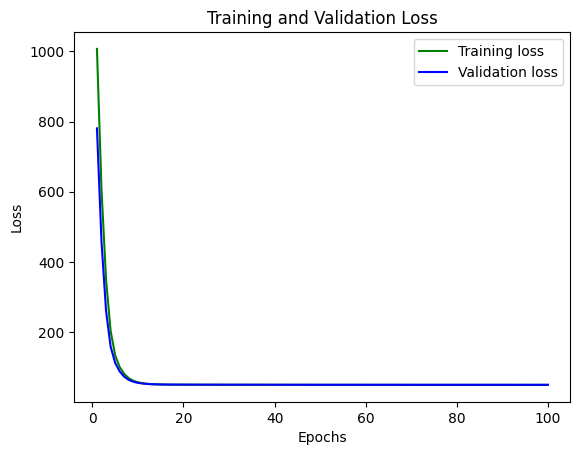

In [ ]:
epochs = range(1, len(training_loss) + 1)
plt.pyplot.plot(epochs, training_loss, 'g', label='Training loss')
plt.pyplot.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.pyplot.title('Training and Validation Loss')
plt.pyplot.xlabel('Epochs')
plt.pyplot.ylabel('Loss')
plt.pyplot.legend()
plt.pyplot.show()

In [ ]:
import matplotlib.pyplot as plt

predictions = model.predict(test_data)
a = plt.axes(aspect='equal')
plt.scatter(test_labels, predictions)
plt.xlabel('True Values [duration]')
plt.ylabel('Predictions [duration]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)